In [1]:
# Importation 
import glob
import numpy as np
import pandas as pd
import seaborn as sns
import os
import openpyxl
from tsfresh import extract_features, select_features
directory = os.getcwd()

# Pré-processing

In [2]:
# Importation données NDVI
donnees = pd.read_csv(f"{directory}/donnees/resultats-2.csv", sep = ";", parse_dates = ["date"], dayfirst = True)
donnees2 = pd.read_csv(f"{directory}/donnees/resultats_new.csv", sep = ";", parse_dates = ["date"], dayfirst = True)

# Typage des colonnes
donnees['parcelle'] = donnees['parcelle'].astype('string')
donnees["parcelle"] = donnees["parcelle"].map(lambda x:x.replace('_','').lower())
donnees.columns = donnees.columns.str.replace('NDVI_moy', 'ndvi')
donnees = donnees.set_index('date', drop = False)

donnees2['parcelle'] = donnees2['parcelle'].astype('string')
donnees2["parcelle"] = donnees2["parcelle"].map(lambda x:x.replace('_','').lower())
donnees2.columns = donnees2.columns.str.replace('NDVI_moy', 'ndvi')
donnees2 = donnees2.set_index('date', drop = False)

donnees["campagne"] = donnees["date"].dt.year # on utilise cette colonne campagne pour les jointures pr récup le peuplement et le précédent
donnees['campagne'] = donnees['campagne'].astype('string')

donnees2["campagne"] = donnees2["date"].dt.year # on utilise cette colonne campagne pour les jointures pr récup le peuplement et le précédent
donnees2['campagne'] = donnees2['campagne'].astype('string')

print(donnees)
print(donnees2)

              parcelle       date  ndvi campagne
date                                            
2022-05-10         222 2022-05-10  3255     2022
2022-06-14         222 2022-06-14  7444     2022
2022-06-19         222 2022-06-19  6815     2022
2022-07-14         222 2022-07-14  5632     2022
2022-07-24         222 2022-07-24  4573     2022
...                ...        ...   ...      ...
2022-08-17  tivillers8 2022-08-17  2002     2022
2022-08-20  tivillers8 2022-08-20  2106     2022
2022-08-22  tivillers8 2022-08-22  1807     2022
2022-08-25  tivillers8 2022-08-25  1835     2022
2022-08-30  tivillers8 2022-08-30  2051     2022

[650 rows x 4 columns]
            Unnamed: 0     parcelle       date  ndvi  NDVI_et campagne
date                                                                  
2022-04-05           2     aubiet11 2022-04-05  1616      969     2022
2022-04-10           3     aubiet11 2022-04-10  1765      900     2022
2022-04-25           4     aubiet11 2022-04-25  2428   

In [3]:
peuplement_1 = pd.read_excel(f"{directory}/donnees/peuplement/donnees2022_BA-2.xlsx", engine='openpyxl', parse_dates = ["date"])
peuplement_1 = peuplement_1.loc[:,["parcelle","date","peuplement"]]

peuplement_2 = pd.read_excel(f"{directory}/donnees/peuplement/Placette_TRN22_beauce.xlsx", engine='openpyxl', parse_dates = ["date_obs"])
peuplement_2 = peuplement_2.loc[:,["numero_parcelle","date_obs","peuplement"]]
peuplement_2.columns = peuplement_2.columns.str.replace('numero_parcelle', 'parcelle')
peuplement_2.columns = peuplement_2.columns.str.replace('date_obs','date')
peuplement_2 = peuplement_2[peuplement_2["parcelle"] != "80_22"] # la dernière ligne a un NA dans col peuplement

peuplement = peuplement_1.merge(peuplement_2)
peuplement = pd.concat([peuplement_1, peuplement_2], axis = 0, ignore_index = True)
peuplement["parcelle"] = peuplement["parcelle"].map(lambda x:x.replace('_','').lower())
peuplement['parcelle'] = peuplement['parcelle'].astype('string')
peuplement = peuplement.groupby(["parcelle"]).agg({"date":["first"], "peuplement":["mean"]})
peuplement.columns = peuplement.columns.droplevel()
peuplement.columns = ["date","peuplement"]
peuplement = peuplement.reset_index()

# Intégration aux données NDVI
peuplement["campagne"] = peuplement["date"].dt.year.map(lambda x:int(x))
peuplement['campagne'] = peuplement['campagne'].astype('string')
peuplement = peuplement.drop(["date"], axis = 1)

donnees = donnees.merge(peuplement,on=['campagne','parcelle'],how='left')

donnees['parcelle'] = donnees['parcelle'].astype('string')
print(donnees)
#donnees = donnees[donnees["parcelle"] == "tivillers8"]
#donnees["ndvi"].plot(title = "Evolution du NDVI sur l'année", ylabel = "NDVI")
#donnees["ndvi"].resample("2W").mean().plot(title = "Evolution du NDVI sur l'année", ylabel = "NDVI")

       parcelle       date  ndvi campagne  peuplement
0           222 2022-05-10  3255     2022         NaN
1           222 2022-06-14  7444     2022         NaN
2           222 2022-06-19  6815     2022         NaN
3           222 2022-07-14  5632     2022         NaN
4           222 2022-07-24  4573     2022         NaN
..          ...        ...   ...      ...         ...
645  tivillers8 2022-08-17  2002     2022     82000.0
646  tivillers8 2022-08-20  2106     2022     82000.0
647  tivillers8 2022-08-22  1807     2022     82000.0
648  tivillers8 2022-08-25  1835     2022     82000.0
649  tivillers8 2022-08-30  2051     2022     82000.0

[650 rows x 5 columns]


In [4]:
donnees = donnees.sort_values(["parcelle","date"])
donnees = donnees.dropna(axis = 0, subset=['peuplement'])

df = donnees.loc[:,["parcelle","date","ndvi"]]
y = donnees.loc[:,["parcelle","peuplement","campagne"]].drop_duplicates().peuplement

y = y.reset_index(drop = True)
df = df.reset_index(drop = True)

In [5]:
print(y)

0     56000.000000
1     75600.000000
2     68000.000000
3     71600.000000
4     43600.000000
5     67200.000000
6     68000.000000
7     57600.000000
8     64400.000000
9     56000.000000
10    56000.000000
11    58800.000000
12    54800.000000
13    50400.000000
14    52000.000000
15    41200.000000
16    33200.000000
17    56800.000000
18    61600.000000
19    62000.000000
20    30000.000000
21    39200.000000
22    48400.000000
23    36416.666667
24    30000.000001
25    60555.555555
26    37666.666668
27    49333.333334
28    29090.909090
29    38181.818182
30    45454.545456
31    43666.666666
32    36952.380952
33    35166.666667
34    30222.222222
35    38000.000000
36    41200.000000
37    79600.000000
38    72000.000000
39    94000.000000
40    82000.000000
Name: peuplement, dtype: float64


In [6]:
date=[]
for i in donnees['date'] :
    a = i.date()
    date.append(a)

In [7]:
print(df["date"])

0     2022-05-10
1     2022-05-30
2     2022-06-14
3     2022-06-19
4     2022-07-14
         ...    
607   2022-08-17
608   2022-08-20
609   2022-08-22
610   2022-08-25
611   2022-08-30
Name: date, Length: 612, dtype: datetime64[ns]


In [8]:
#transformation des jours en jour julien
date_jour_julien = []
for i in date :
    if i.month <=5 :
        date_jour_julien.append((i.month-1)*30+i.day) 
    elif i.month <=7:
        date_jour_julien.append((i.month-1)*30+i.day+1)
    elif i.month ==8 :
        date_jour_julien.append((i.month-1)*30+i.day+2)




In [9]:
print(donnees)

       parcelle       date  ndvi campagne  peuplement
27         1722 2022-05-10  3606     2022     56000.0
28         1722 2022-05-30  7392     2022     56000.0
29         1722 2022-06-14  7679     2022     56000.0
30         1722 2022-06-19  7855     2022     56000.0
31         1722 2022-07-14  4981     2022     56000.0
..          ...        ...   ...      ...         ...
645  tivillers8 2022-08-17  2002     2022     82000.0
646  tivillers8 2022-08-20  2106     2022     82000.0
647  tivillers8 2022-08-22  1807     2022     82000.0
648  tivillers8 2022-08-25  1835     2022     82000.0
649  tivillers8 2022-08-30  2051     2022     82000.0

[612 rows x 5 columns]


In [10]:
record =[]
for i in range (len(date)):
    a= [date[i],date_jour_julien[i]]
    record.append(a)

In [11]:
df_date = pd.DataFrame (record,columns=["date","date_jour_julien"]) 
print(df_date)

           date  date_jour_julien
0    2022-05-10               130
1    2022-05-30               150
2    2022-06-14               165
3    2022-06-19               170
4    2022-07-14               195
..          ...               ...
607  2022-08-17               229
608  2022-08-20               232
609  2022-08-22               234
610  2022-08-25               237
611  2022-08-30               242

[612 rows x 2 columns]


In [12]:
new_df= pd.concat([df,df_date],axis=1)

In [13]:
print(new_df)


       parcelle       date  ndvi        date  date_jour_julien
0          1722 2022-05-10  3606  2022-05-10               130
1          1722 2022-05-30  7392  2022-05-30               150
2          1722 2022-06-14  7679  2022-06-14               165
3          1722 2022-06-19  7855  2022-06-19               170
4          1722 2022-07-14  4981  2022-07-14               195
..          ...        ...   ...         ...               ...
607  tivillers8 2022-08-17  2002  2022-08-17               229
608  tivillers8 2022-08-20  2106  2022-08-20               232
609  tivillers8 2022-08-22  1807  2022-08-22               234
610  tivillers8 2022-08-25  1835  2022-08-25               237
611  tivillers8 2022-08-30  2051  2022-08-30               242

[612 rows x 5 columns]


In [14]:
newdf = new_df.drop(['date'], axis=1)

In [15]:
# Stockage des données ndvi et leur index en jour de l'année associé dans une liste de liste 
parcelle_nb = df["parcelle"].drop_duplicates().values.tolist()
print(parcelle_nb)
groups = newdf.groupby(['parcelle'])
doy_ndvi = []
for name in parcelle_nb : 
    doy_ndvi.append([groups.get_group(name)['date_jour_julien'].values.tolist(),groups.get_group(name)['ndvi'].values.tolist()])
print(doy_ndvi[:10])

['1722', '2822', '2922', '3822', '4222', '4422', '4522', '4722', '5222', '5322', '5422', '6222', '6322', '6622', '6722', '7122', '7322', '7422', '7522', '7622', '7822', '8222', '8822', 'aubiet11', 'aubiet22', 'coulonges2', 'fdgeda1', 'fdgeda2', 'fdgeda6', 'fdgeda7', 'fdgeda8', 'lamagistere3', 'tiagen1', 'tiravard1', 'tirosieres1', 'tirosieres3', 'tirosieres4', 'tivillers5', 'tivillers6', 'tivillers7', 'tivillers8']
[[[130, 150, 165, 170, 195, 205, 215, 220, 225], [3606, 7392, 7679, 7855, 4981, 6421, 4475, 3795, 3458]], [[130, 150, 165, 170, 195, 205, 215, 220, 225], [2808, 7321, 6390, 7689, 4915, 4632, 3579, 3426, 3103]], [[100, 130, 150, 165, 170, 195, 205, 215, 220, 225], [1633, 2381, 7082, 6419, 7486, 4967, 4808, 3219, 2991, 2685]], [[100, 130, 150, 165, 170, 195, 205, 215, 220, 225], [1479, 1673, 7711, 7945, 8177, 6858, 7747, 4773, 3448, 3650]], [[100, 130, 150, 165, 170, 195, 205, 215, 220, 225, 240], [2231, 3310, 5527, 7316, 7164, 6658, 7114, 5303, 3939, 3058, 2344]], [[100, 130,

In [16]:
parcelle_nb = df["parcelle"].drop_duplicates().values.tolist()
print(parcelle_nb)
groups = newdf.groupby(['parcelle'])
new_ndvi = []
for name in parcelle_nb : 
    new_ndvi.append(groups.get_group(name)['ndvi'].values.tolist())

['1722', '2822', '2922', '3822', '4222', '4422', '4522', '4722', '5222', '5322', '5422', '6222', '6322', '6622', '6722', '7122', '7322', '7422', '7522', '7622', '7822', '8222', '8822', 'aubiet11', 'aubiet22', 'coulonges2', 'fdgeda1', 'fdgeda2', 'fdgeda6', 'fdgeda7', 'fdgeda8', 'lamagistere3', 'tiagen1', 'tiravard1', 'tirosieres1', 'tirosieres3', 'tirosieres4', 'tivillers5', 'tivillers6', 'tivillers7', 'tivillers8']


In [17]:
print(type(y))

<class 'pandas.core.series.Series'>


In [18]:
new_y = np.array(y)
donnees_array = donnees.to_numpy()

In [19]:
print(np.shape(donnees_array))

(612, 5)


In [20]:
print(type(new_y))

<class 'numpy.ndarray'>


In [21]:
print(new_y.astype(int))

[56000 75600 68000 71600 43600 67200 68000 57600 64400 56000 56000 58800
 54800 50400 52000 41200 33200 56800 61600 62000 30000 39200 48400 36416
 30000 60555 37666 49333 29090 38181 45454 43666 36952 35166 30222 38000
 41200 79600 72000 94000 82000]


In [22]:
print(np.shape(new_y))

(41,)


In [23]:
new_y= new_y.astype(int)
new_y = new_y.reshape(41,)

In [24]:
print((new_y))

[56000 75600 68000 71600 43600 67200 68000 57600 64400 56000 56000 58800
 54800 50400 52000 41200 33200 56800 61600 62000 30000 39200 48400 36416
 30000 60555 37666 49333 29090 38181 45454 43666 36952 35166 30222 38000
 41200 79600 72000 94000 82000]


In [81]:
a = np.array([1, 2, 3, 4, 5])
print(np.shape(a))
print(a)
b = a.reshape(5,1)
print(np.shape(b))
print(b)
c = a.reshape(1,5)
print(np.shape(c))
print(c)

(5,)
[1 2 3 4 5]
(5, 1)
[[1]
 [2]
 [3]
 [4]
 [5]]
(1, 5)
[[1 2 3 4 5]]


## INTERPOLATION

In [26]:
liste =  [2,4,5,6,7,3,4,5,6]
print (len(liste))

9


In [27]:
print(type(doy_ndvi))
print(doy_ndvi)

<class 'list'>
[[[130, 150, 165, 170, 195, 205, 215, 220, 225], [3606, 7392, 7679, 7855, 4981, 6421, 4475, 3795, 3458]], [[130, 150, 165, 170, 195, 205, 215, 220, 225], [2808, 7321, 6390, 7689, 4915, 4632, 3579, 3426, 3103]], [[100, 130, 150, 165, 170, 195, 205, 215, 220, 225], [1633, 2381, 7082, 6419, 7486, 4967, 4808, 3219, 2991, 2685]], [[100, 130, 150, 165, 170, 195, 205, 215, 220, 225], [1479, 1673, 7711, 7945, 8177, 6858, 7747, 4773, 3448, 3650]], [[100, 130, 150, 165, 170, 195, 205, 215, 220, 225, 240], [2231, 3310, 5527, 7316, 7164, 6658, 7114, 5303, 3939, 3058, 2344]], [[100, 130, 150, 165, 170, 195, 205, 215, 220, 225], [2235, 4586, 7896, 7891, 7848, 5548, 7146, 5333, 4716, 4389]], [[100, 130, 150, 165, 170, 195, 205, 215, 220, 225], [8680, 5639, 8423, 7026, 5228, 2112, 1837, 1461, 1578, 1523]], [[100, 130, 150, 165, 170, 195, 205, 215, 220, 225], [2248, 4204, 6281, 7485, 7354, 5894, 6770, 4782, 3872, 3347]], [[100, 130, 150, 165, 170, 195, 205, 215, 220, 225], [7685, 6232, 7

In [28]:
debut = [ doy_ndvi[k][0][0] for k in  range (len(doy_ndvi))]
fin = [ doy_ndvi[k][0][-1]  for k in  range (len(doy_ndvi))]
le = [len(doy_ndvi[k][0])for k in range(len(doy_ndvi))]
print(debut,fin,le)
print(min(debut),max(fin))


[130, 130, 100, 100, 100, 100, 100, 100, 100, 130, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 95, 95, 113, 100, 100, 100, 100, 100, 100, 100, 123, 94, 94, 94, 94, 94, 94, 94] [225, 225, 225, 225, 240, 225, 225, 225, 225, 240, 240, 225, 225, 240, 225, 225, 225, 225, 240, 240, 240, 225, 225, 240, 240, 223, 240, 240, 240, 240, 240, 240, 240, 223, 242, 242, 242, 242, 242, 242, 242] [9, 9, 10, 10, 11, 10, 10, 10, 10, 16, 11, 9, 9, 18, 18, 10, 10, 17, 18, 16, 11, 9, 10, 16, 16, 14, 14, 13, 11, 11, 11, 11, 17, 12, 30, 29, 29, 28, 28, 26, 25]
94 242


## Création d'une liste de date pour tous les jours

In [29]:
all_dates=[]
for i in range (94,243):
    all_dates.append(i)
print(all_dates)

[94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232, 233, 234, 235, 236, 237, 238, 239, 240, 241, 242]


In [30]:
tous_les_jours = []
for i in range (len(doy_ndvi)):
    indice = []
    val = []
    indi2=0
    for j in range(doy_ndvi[i][0][0],doy_ndvi[i][0][-1]+1):
        if j in doy_ndvi[i][0]:
            indice.append(j)
            val.append(doy_ndvi[i][1][indi2])
            indi2+=1
        else : 
            indice.append(j)
            val.append(np.nan)
    tous_les_jours.append([indice,val])

In [31]:
tous_les_jours_df = pd.DataFrame([tous_les_jours[0]], columns= ('jour','ndvi'))

In [32]:
print(tous_les_jours_df['ndvi'].interpolate())

0    [3606, nan, nan, nan, nan, nan, nan, nan, nan,...
Name: ndvi, dtype: object


In [33]:
data1 = pd.DataFrame(columns=['jour','ndvi'])
print(data1)


Empty DataFrame
Columns: [jour, ndvi]
Index: []


In [34]:
#On repasse tout ça en dataframe que l'on stocke dans une liste pour pouvoir utiliser l'interpolation
datalist = []
for parc in tous_les_jours : 
    datalist.append(pd.DataFrame(parc[0], columns= ['jour']))
    datalist[-1]["ndvi"] = parc[1]
print(datalist)

[    jour    ndvi
0    130  3606.0
1    131     NaN
2    132     NaN
3    133     NaN
4    134     NaN
..   ...     ...
91   221     NaN
92   222     NaN
93   223     NaN
94   224     NaN
95   225  3458.0

[96 rows x 2 columns],     jour    ndvi
0    130  2808.0
1    131     NaN
2    132     NaN
3    133     NaN
4    134     NaN
..   ...     ...
91   221     NaN
92   222     NaN
93   223     NaN
94   224     NaN
95   225  3103.0

[96 rows x 2 columns],      jour    ndvi
0     100  1633.0
1     101     NaN
2     102     NaN
3     103     NaN
4     104     NaN
..    ...     ...
121   221     NaN
122   222     NaN
123   223     NaN
124   224     NaN
125   225  2685.0

[126 rows x 2 columns],      jour    ndvi
0     100  1479.0
1     101     NaN
2     102     NaN
3     103     NaN
4     104     NaN
..    ...     ...
121   221     NaN
122   222     NaN
123   223     NaN
124   224     NaN
125   225  3650.0

[126 rows x 2 columns],      jour    ndvi
0     100  2231.0
1     101     NaN
2     1

In [35]:
print (type(datalist))

<class 'list'>


In [36]:
print(datalist[0:1][0][0:2])

   jour    ndvi
0   130  3606.0
1   131     NaN


In [37]:
# On remplace les donnees manquantes par interpolation linaires 
df_interpolate = [ k.interpolate() for k in datalist]


In [38]:
ndvi2 = [[k['jour'].values.tolist() , k['ndvi'].values.tolist()] for k in df_interpolate]

In [39]:
print(ndvi2[0])

[[130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 225], [3606.0, 3795.3, 3984.6, 4173.9, 4363.2, 4552.5, 4741.8, 4931.1, 5120.4, 5309.7, 5499.0, 5688.3, 5877.6, 6066.9, 6256.200000000001, 6445.5, 6634.8, 6824.1, 7013.4, 7202.700000000001, 7392.0, 7411.133333333333, 7430.266666666666, 7449.4, 7468.533333333334, 7487.666666666667, 7506.8, 7525.933333333333, 7545.066666666667, 7564.2, 7583.333333333333, 7602.466666666666, 7621.6, 7640.733333333334, 7659.866666666667, 7679.0, 7714.2, 7749.4, 7784.6, 7819.8, 7855.0, 7740.04, 7625.08, 7510.12, 7395.16, 7280.2, 7165.24, 705

In [40]:
print(len(ndvi2))

41


In [41]:
list_all_day = []
for i in range (len(ndvi2)):
    indice = []
    val = []
    indi2=0
    for j in range(min(debut),max(fin)+1):
        if j in ndvi2[i][0]:
            indice.append(j)
            val.append(ndvi2[i][1][indi2])
            indi2+=1
        else : 
            indice.append(j)
            val.append(np.nan)
    list_all_day.append([indice,val])

In [42]:
print(list_all_day[0])

[[94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232, 233, 234, 235, 236, 237, 238, 239, 240, 241, 242], [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, 3606.0, 3795.3, 3984.6, 4173.9, 4363.2, 4552.5, 4741.8, 4931.1, 5120.4, 5309.

In [43]:
cut_all_day = []
for i in range (len(ndvi2)):
    indice = []
    val = []
    indi2=0
    for j in range(max(debut),min(fin)+1):
        if j in ndvi2[i][0]:
            indice.append(j)
            val.append(ndvi2[i][1][indi2])
            indi2+=1
        else : 
            indice.append(j)
            val.append(np.nan)
    cut_all_day.append([indice,val])

In [44]:
print(cut_all_day[40])

[[130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223], [1425.0, 1442.6153846153845, 1460.2307692307693, 1477.8461538461538, 1495.4615384615386, 1513.076923076923, 1530.6923076923076, 1548.3076923076924, 1565.923076923077, 1583.5384615384614, 1601.1538461538462, 1618.7692307692307, 1636.3846153846155, 1654.0, 1779.2, 1904.4, 2029.6, 2154.8, 2280.0, 2233.4166666666665, 2186.8333333333335, 2140.25, 2093.6666666666665, 2047.0833333333333, 2000.5, 1953.9166666666665, 1907.3333333333333, 1860.75, 1814.1666666666665, 1767.5833333333333, 1721.0, 1738.6666666666667, 1756.3333333333333

In [45]:
all_ndvi =[]
for parc in cut_all_day : 
    all_ndvi.append(np.array(parc[1]))

In [46]:
all_ndvi_array = np.array(all_ndvi)

In [47]:
print(np.shape(all_ndvi_array))

(41, 94)


In [48]:
print(new_y)

[56000 75600 68000 71600 43600 67200 68000 57600 64400 56000 56000 58800
 54800 50400 52000 41200 33200 56800 61600 62000 30000 39200 48400 36416
 30000 60555 37666 49333 29090 38181 45454 43666 36952 35166 30222 38000
 41200 79600 72000 94000 82000]


In [49]:
test_class_y =[]
for i in range(len(new_y)): 
    if new_y[i] > 60000 : 
        test_class_y.append(2)
    elif new_y[i] > 45000 : 
        test_class_y.append(1)
    else : 
        test_class_y.append(0)
print(test_class_y)

[1, 2, 2, 2, 0, 2, 2, 1, 2, 1, 1, 1, 1, 1, 1, 0, 0, 1, 2, 2, 0, 0, 1, 0, 0, 2, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2]


In [50]:
class1 = 0
class2 = 0
class0 = 0
for i in range(len(test_class_y)):
    if test_class_y[i] ==1 :
        class1 += 1
    elif test_class_y[i] ==2 : 
        class2 += 1
    else :
        class0 += 1

print (class0,class1,class2)

16 12 13


In [51]:
# Author: Romain Tavenard
# License: BSD 3 clause

import numpy
from sklearn.metrics import accuracy_score
import tensorflow as tf
import matplotlib.pyplot as plt

from tslearn.datasets import CachedDatasets
from tslearn.preprocessing import TimeSeriesScalerMinMax
from tslearn.shapelets import LearningShapelets, \
    grabocka_params_to_shapelet_size_dict
from tslearn.utils import ts_size
from sklearn.model_selection import GridSearchCV, cross_val_score, train_test_split

2023-02-09 11:54:52.677418: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
/Users/louis/opt/miniconda3/lib/python3.9/site-packages/requests/__init__.py:102: RequestsDependencyWarning: urllib3 (1.26.8) or chardet (5.0.0)/charset_normalizer (2.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({})/charset_normalizer ({}) doesn't match a supported "


In [52]:
# Set seed for determinism
numpy.random.seed(0)

# Load the Trace dataset
X_train, X_test, y_train, y_test = train_test_split(all_ndvi_array, test_class_y, test_size=0.25, random_state=0)

In [53]:
# Normalize each of the timeseries in the Trace dataset
X_train = TimeSeriesScalerMinMax().fit_transform(X_train)
X_test = TimeSeriesScalerMinMax().fit_transform(X_test)


In [54]:
print(y_train)

[0, 2, 2, 2, 2, 0, 1, 0, 2, 2, 1, 2, 1, 1, 0, 1, 0, 2, 0, 1, 0, 0, 2, 0, 0, 2, 1, 2, 2, 1]


In [55]:
print(set(y_train))

{0, 1, 2}


In [56]:
print (X_train.shape[:2])
print(len(set(y_train)))

(30, 94)
3


In [57]:
# Get statistics of the dataset
n_ts, ts_sz = X_train.shape[:2]
n_classes = len(set(y_train))


In [58]:

# Set the number of shapelets per size as done in the original paper
shapelet_sizes = grabocka_params_to_shapelet_size_dict(n_ts=n_ts,
                                                       ts_sz=ts_sz,
                                                       n_classes=n_classes,
                                                       l=0.1,
                                                       r=1)

In [59]:
print(shapelet_sizes)

{9: 3}


In [60]:
print(int(6.8))

6


In [61]:
# Define the model using parameters provided by the authors (except that we
# use fewer iterations here)
shp_clf = LearningShapelets(n_shapelets_per_size = shapelet_sizes)

/Users/louis/opt/miniconda3/lib/python3.9/site-packages/tslearn/shapelets/shapelets.py:354: FutureWarning: The default value for 'scale' is set to False in version 0.4 to ensure backward compatibility, but is likely to change in a future version.
  warnings.warn("The default value for 'scale' is set to False "


In [62]:
shp_clf.fit(X_train, y_train)

2023-02-09 11:55:10.361714: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


LearningShapelets(n_shapelets_per_size={9: 3})

In [63]:
# Make predictions and calculate accuracy score
pred_labels = shp_clf.predict(X_test)
print("Correct classification rate:", accuracy_score(y_test, pred_labels))

Correct classification rate: 0.09090909090909091


In [64]:
print (pred_labels)
print(y_test)

[2 2 2 2 2 2 2 2 2 2 2]
[2, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0]


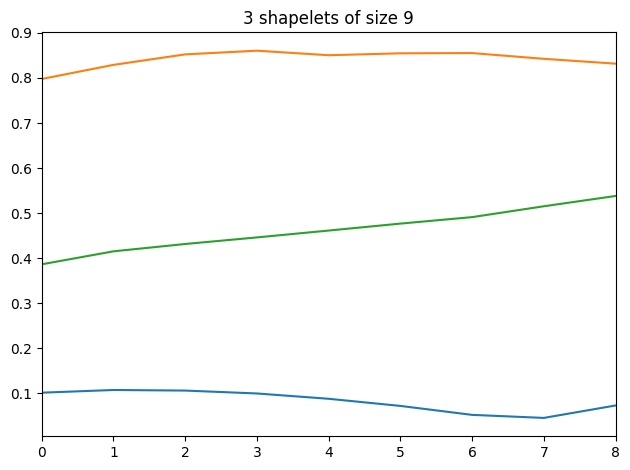

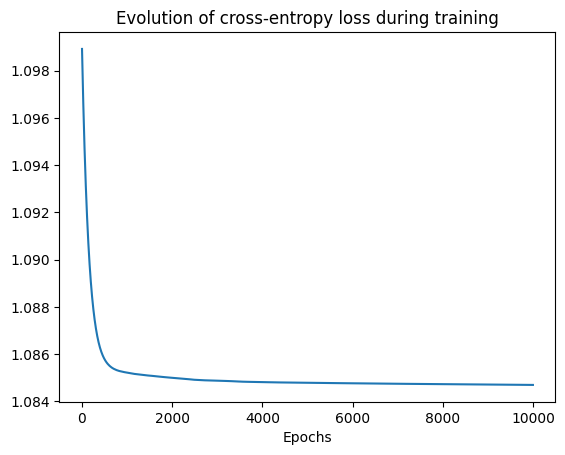

In [65]:
# Plot the different discovered shapelets
plt.figure()
for i, sz in enumerate(shapelet_sizes.keys()):
    plt.subplot(len(shapelet_sizes), 1, i + 1)
    plt.title("%d shapelets of size %d" % (shapelet_sizes[sz], sz))
    for shp in shp_clf.shapelets_:
        if ts_size(shp) == sz:
            plt.plot(shp.ravel())
    plt.xlim([0, max(shapelet_sizes.keys()) - 1])

plt.tight_layout()
plt.show()

# The loss history is accessible via the `model_` that is a keras model
plt.figure()
plt.plot(numpy.arange(1, shp_clf.n_iter_ + 1), shp_clf.history_["loss"])
plt.title("Evolution of cross-entropy loss during training")
plt.xlabel("Epochs")
plt.show()

In [66]:
import math
import random
import numpy
from matplotlib import pyplot
from matplotlib import cm
from sklearn.preprocessing import StandardScaler
from tslearn.clustering import TimeSeriesKMeans
import torch
from torch import nn, optim

/Users/louis/opt/miniconda3/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [67]:
# Path to root of this project, contains lots of modules
import sys
sys.path.insert(0, os.path.abspath('../'))
sys.path.insert(0, os.getcwd())

In [68]:
from src.learning_shapelets import LearningShapelets

In [69]:
def normalize_standard(X, scaler=None):
    shape = X.shape
    data_flat = X.flatten()
    if scaler is None:
        scaler = StandardScaler()
        data_transformed = scaler.fit_transform(data_flat.reshape(numpy.product(shape), 1)).reshape(shape)
    else:
        data_transformed = scaler.transform(data_flat.reshape(numpy.product(shape), 1)).reshape(shape)
    return data_transformed, scaler

def normalize_data(X, scaler=None):
    if scaler is None:
        X, scaler = normalize_standard(X)
    else:
        X, scaler = normalize_standard(X, scaler)
    
    return X, scaler

In [73]:
# normalize training data
X_train, scaler = normalize_data(X_train)

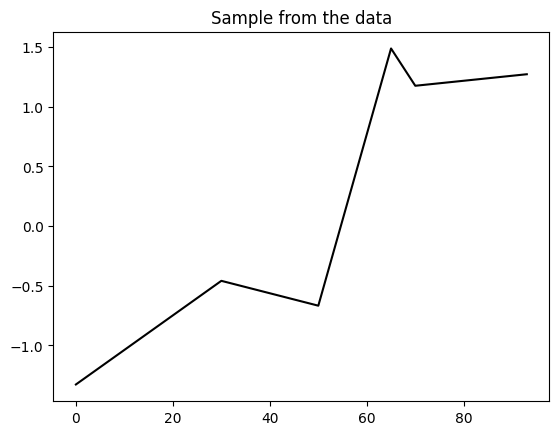

In [77]:
pyplot.title("Sample from the data")
pyplot.plot(X_train[0], color='black')

In [78]:
print(X_train.shape)

(30, 94, 1)


In [ ]:
np.reshape(X_train[0])

In [ ]:
def sample_ts_segments(X, shapelets_size, n_segments=10000):
    """
    Sample time series segments for k-Means.
    """
    n_ts, n_channels, len_ts = X.shape
    samples_i = random.choices(range(n_ts), k=n_segments)
    segments = numpy.empty((n_segments, n_channels, shapelets_size))
    for i, k in enumerate(samples_i):
        s = random.randint(0, len_ts - shapelets_size)
        segments[i] = X[k, :, s:s+shapelets_size]
    return segments